In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Optional: If model won't load from huggingface, this install fixes that

In [4]:
!pip install --upgrade "huggingface_hub[hf_xet]" transformers

## Imports

In [17]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,RobertaTokenizer,RobertaForSequenceClassification, RobertaModel, RobertaConfig
from torch.utils.data import Dataset
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch import nn
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

## Paths

In [4]:
train_path = '/content/drive/MyDrive/NLI/train.csv'
dev_path = '/content/drive/MyDrive/NLI/dev.csv'

In [5]:
tokeniser = RobertaTokenizer.from_pretrained("roberta-large")
#model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

## Collate function

In [6]:
def collate(batch):
    input_ids_list = []
    start_idxs = []
    end_idxs = []
    span_masks = []
    labels = []
    max_len = 512

    #each example in the batch is looped through
    for item in batch:
        #premise and hypothesis are tokenised, also padded to the max length and truncated if greater than the max length
        enc =tokeniser(
            item["premise"],
            item["hypothesis"],
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=max_len

        )

        input_ids = enc["input_ids"].squeeze(0)

        #length without padding is calculated
        token_len = (input_ids != tokeniser.pad_token_id).sum().item()

        #generate all possible spans of length 1: (i, i+1) for valid token positions
        span_start = torch.arange(1, token_len - 2)
        span_end = span_start + 1
        span_mask = torch.zeros_like(span_start).float()

        #pad span index and masks so they're the same length
        input_ids_list.append(input_ids)
        start_idxs.append(span_start)
        end_idxs.append(span_end)
        span_masks.append(span_mask)
        labels.append(torch.tensor(item["label"]))

    start_idxs = pad_sequence(start_idxs, batch_first=True)
    end_idxs = pad_sequence(end_idxs, batch_first=True)
    span_masks = pad_sequence(span_masks, batch_first=True)

    #return tokenised inputs, span start/end indexes, span masks and labels
    return(
        torch.stack(input_ids_list),
        start_idxs,
        end_idxs,
        span_masks,
        torch.stack(labels).float()
    )

## Model

In [ ]:
# Code for model taken from: https://github.com/ShannonAI/Self_Explaining_Structures_Improve_NLP_Models/blob/master/explain/model.py
# Mainly the explainable model class and interpretation model class were used.
# Paper: https://arxiv.org/pdf/2012.01786v2

In [7]:
class ExplainableModel(nn.Module):
    #RoBERTa used to encode input sequences
    #span-based features using SIC obtained
    #interpretation used to weight the spans and generates explainable summary
    #prediction is a combination of most relevant spans
    def __init__(self, bert_dir):
        super().__init__()
        self.bert_config = RobertaConfig.from_pretrained(bert_dir, num_labels=2)
        self.intermediate = RobertaModel.from_pretrained(bert_dir)
        self.span_info_collect = SICModel(self.bert_config.hidden_size)
        self.interpretation = InterpretationModel(self.bert_config.hidden_size)
        self.output = nn.Linear(self.bert_config.hidden_size, 1)

    def forward(self, input_ids, start_indexs, end_indexs, span_masks):
        # generate mask
        attention_mask = (input_ids != 1).long()
        # intermediate layer
        hidden_states = self.intermediate(input_ids, attention_mask=attention_mask).last_hidden_state
        # span info collecting layer(SIC)
        h_ij = self.span_info_collect(hidden_states, start_indexs, end_indexs)
        # interpretation layer
        H, a_ij = self.interpretation(h_ij, span_masks)
        # output layer
        out = self.output(H)
        return out, a_ij


class SICModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        #linear transformations for different span endpoints
        self.W_1 = nn.Linear(hidden_size, hidden_size) #start token
        self.W_2 = nn.Linear(hidden_size, hidden_size) #end token
        self.W_3 = nn.Linear(hidden_size, hidden_size) #start and end difference
        self.W_4 = nn.Linear(hidden_size, hidden_size) #start and end interaction

    def forward(self, hidden_states, start_indexs, end_indexs):
        # hidden_states: (batch_size, seq_len, hidden_size)
        # start_indexs / end_indexs: (batch_size, span_len)

        batch_size, seq_len, hidden_size = hidden_states.size()
        span_len = start_indexs.size(1)

        #transformations applied in batch
        W1_h = self.W_1(hidden_states)
        W2_h = self.W_2(hidden_states)
        W3_h = self.W_3(hidden_states)
        W4_h = self.W_4(hidden_states)

        #transformed embeddings collected for each span
        W1_hi_emb = [] #collect transformed start token embeddings
        W2_hj_emb = [] #collect transformed end token embeddings
        W3_hi_start_emb = [] #(h_i - h_j)
        W3_hi_end_emb = []
        W4_hj_start_emb = [] #(h_i * h_j)
        W4_hj_end_emb = []

        #iterate through each item in batch, select transformed hidden states
        #at span positions, this collects span representations per example
        for b in range(batch_size):
            si = start_indexs[b]
            ei = end_indexs[b]

            W1_hi_emb.append(W1_h[b].index_select(0, si))
            W2_hj_emb.append(W2_h[b].index_select(0, ei))
            W3_hi_start_emb.append(W3_h[b].index_select(0, si))
            W3_hi_end_emb.append(W3_h[b].index_select(0, ei))
            W4_hj_start_emb.append(W4_h[b].index_select(0, si))
            W4_hj_end_emb.append(W4_h[b].index_select(0, ei))

        #embeddings now stacked to give tensor shape = (batch_size, span_len, hidden_size)
        W1_hi_emb = torch.stack(W1_hi_emb)
        W2_hj_emb = torch.stack(W2_hj_emb)
        W3_hi_start_emb = torch.stack(W3_hi_start_emb)
        W3_hi_end_emb = torch.stack(W3_hi_end_emb)
        W4_hj_start_emb = torch.stack(W4_hj_start_emb)
        W4_hj_end_emb = torch.stack(W4_hj_end_emb)

        #combine span representations
        span = (
            W1_hi_emb +
            W2_hj_emb +
            (W3_hi_start_emb - W3_hi_end_emb) +
            torch.mul(W4_hj_start_emb, W4_hj_end_emb)
        )

        h_ij=torch.tanh(span)
        return h_ij

class InterpretationModel(nn.Module):
    #assign importance weights for each span
    #linear scoring layer for all span representations
    #span masks used to mask illegal spans
    #softmax to normalise attention weights
    #weighted average of spans gives final sentence representation (H)
    def __init__(self, hidden_size):
        super().__init__()
        self.h_t = nn.Linear(hidden_size, 1)

    def forward(self, h_ij, span_masks):
        o_ij = self.h_t(h_ij).squeeze(-1)  # (ba, span_num)
        # mask illegal span
        o_ij = o_ij - span_masks
        # normalize all a_ij, a_ij sum = 1
        a_ij = nn.functional.softmax(o_ij, dim=1)
        # weight average span representation to get H
        H = (a_ij.unsqueeze(-1) * h_ij).sum(dim=1)  # (bs, hidden_size)
        return H, a_ij


## Dataloading and model loading

In [8]:
#the dataset loads the csv file, with headers: premise, hypothesis and label
#it retuns a dictionary that represents a single sample with those fields
class NliDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "premise": str(row["premise"]),
            "hypothesis": str(row["hypothesis"]),
            "label": float(row["label"]),
        }

In [9]:
device = "cuda"

In [9]:
#model loading and dataset loading
model = ExplainableModel("roberta-large").to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
train_dataset = NliDataset(train_path)
dev_dataset = NliDataset(dev_path)

In [14]:
#dataloading with the collate function and batch size set to 8 since it uses
#a lot of gpu ram
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate)
val_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False, collate_fn=collate)

In [15]:
#loss function and optimiser defined
loss_fn = nn.BCEWithLogitsLoss()
optimiser = AdamW(model.parameters(), lr=0.000005, weight_decay=0.0001)

## Training and evaluation loop

In [13]:
def evaluate(model, val_loader, device, loss_fn):
    #evaluation metrics computed each loop in training to ensure no overfitting
    #and general evaluation of the training
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for input_ids, start_idxs, end_idxs, span_masks, labels in val_loader:
            input_ids = input_ids.to(device)
            start_idxs = start_idxs.to(device)
            end_idxs = end_idxs.to(device)
            span_masks = span_masks.to(device)
            labels = labels.to(device)

            logits, _ = model(input_ids, start_idxs, end_idxs, span_masks)
            logits = logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    val_acc = accuracy_score(all_labels, binary_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader)

    precision = precision_score(all_labels, binary_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, binary_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, binary_preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(all_labels, binary_preds)

    return val_acc, val_auc, val_loss, precision, recall, f1, mcc

In [14]:
def train(model, train_loader, val_loader, optimiser, loss_fn, device, epochs=3):
    best_acc = 0
    #for each epoch, set the model to training mode, calculate loss for that epoch and predictions and labels
    #for each batch:
    #    -Move inputs (input_ids, span indices, span masks, labels) to the correct device
    #    -Forward pass to get model predictions (logits) and span attention weights
    #    -Compute binary classification loss
    #    -Zero out previous gradients
    #    -Backpropagate the loss
    #    -Update model parameters using the optimiser
    #    -Track training loss and batch-wise accuracy
    #then we evaluate the model on the validation set, training loss and validation loss used to evaluate overfitting
    #print training and validation performance, then save the model if it the best
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for input_ids, start_idxs, end_idxs, span_masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = input_ids.to(device)
            start_idxs = start_idxs.to(device)
            end_idxs = end_idxs.to(device)
            span_masks = span_masks.to(device)
            labels = labels.to(device)

            logits, _ = model(input_ids, start_idxs, end_idxs, span_masks)
            logits = logits.squeeze(-1)
            loss = loss_fn(logits, labels)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]
        train_acc = accuracy_score(all_labels, binary_preds)
        avg_loss = total_loss / len(train_loader)

        val_acc, _, val_loss, _, _, _, _ = evaluate(model, val_loader, device, loss_fn)

        print(
            "Epoch", epoch + 1, "|",
            "Train Loss:", round(avg_loss, 4), "|",
            "Train Acc:", round(train_acc, 4), "|",
            "Val Loss:", round(val_loss, 4), "|",
            "Val Acc:", round(val_acc, 4)
        )

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/NLI/best_model_Transformer_Base_Test.pt")
            print("Saved new best model")


In [15]:
train(model, train_loader, val_loader, optimiser, loss_fn, device, epochs=4)

Epoch 1: 100%|██████████| 3054/3054 [17:35<00:00,  2.89it/s]


Epoch 1 | Train Loss: 0.4129 | Train Acc: 0.8063 | Val Loss: 0.3118 | Val Acc: 0.8697
Saved new best model


Epoch 2:  12%|█▏        | 370/3054 [02:07<15:27,  2.89it/s]


KeyboardInterrupt: 

## Run this cell if you want to evaluate best current model. Ignore if you want to evaluate after training loop

In [10]:
model = ExplainableModel("roberta-large").to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/NLI/best_model_Transformer_Large_new.pt"))
model.to(device)
model.eval()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ExplainableModel(
  (intermediate): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
        

In [11]:
def evaluate_separate(model, val_loader, device, loss_fn):
    #evaluation metrics computed each loop in training to ensure no overfitting
    #and general evaluation of the training
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for input_ids, start_idxs, end_idxs, span_masks, labels in val_loader:
            input_ids = input_ids.to(device)
            start_idxs = start_idxs.to(device)
            end_idxs = end_idxs.to(device)
            span_masks = span_masks.to(device)
            labels = labels.to(device)

            logits, _ = model(input_ids, start_idxs, end_idxs, span_masks)
            logits = logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    val_acc = accuracy_score(all_labels, binary_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader)

    precision = precision_score(all_labels, binary_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, binary_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, binary_preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(all_labels, binary_preds)
    conf_mat = confusion_matrix(all_labels, binary_preds)

    return val_acc, val_auc, val_loss, precision, recall, f1, mcc, conf_mat

In [16]:
#evaluation metrics of final model printed
val_acc, val_auc, val_loss, precision, recall, f1, mcc, conf_mat = evaluate_separate(model, val_loader, device, loss_fn)
print("Validation Accuracy: ", val_acc)
print("Validation AUC: ", val_auc)
print("Validation Precision: ", precision)
print("Validation Recall: ", recall)
print("Validation F1: ", f1)
print("Validation MCC: ", mcc)
print("Validation Loss: ", val_loss)

Validation Accuracy:  0.9153800475059383
Validation AUC:  0.9720576342182078
Validation Precision:  0.9153878674152803
Validation Recall:  0.9151731960007498
Validation F1:  0.9152688695983773
Validation MCC:  0.8305610356734481
Validation Loss:  0.21928417179379567


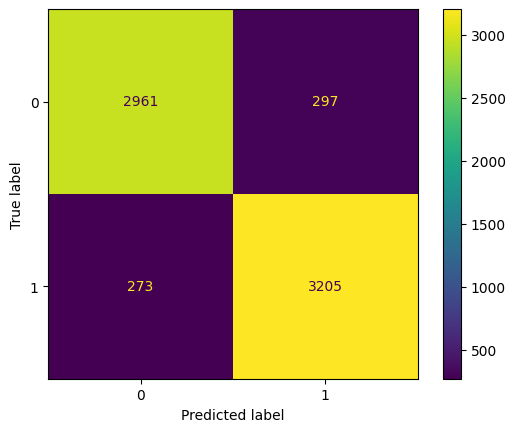

In [18]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0, 1])
cm_display.plot()
plt.show()